<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pycaret as pc
import missingno as msno

from pandas_profiling import ProfileReport

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

---
### Project outline and methodology

To achieve the required parameters of the project we will:
1. First load and clean the data, filling all missing values.
2. EDA and understanding the data
3. Divide the data in to Fixed and Reno (Fixed = Question 1, Reno = Question 2)
4. Prepare a baseline model
5. Feature engineering
6. Test different models and inference feature importance for Q1
7. Do some EDA on the Reno features using the residuals from Q1 as target
8. Repeat steps 4,5 and 6 for Q2 using the residuals from Q1 as the target.

`note: This is a top-down approach to the methodology and project as a whole. I it may change, we will have to see what the data shows us.`

###  1. Loading and cleaning the data


In [2]:
# Load the data
house = pd.read_csv('./DSI/Unit-3-Restructured/Project-3/housing.csv')

In [3]:
# Changing the column names to lowercase
house.columns = [columns.lower() for columns in house.columns]

In [4]:
# looking at the shape of the dataset
house.shape

(1460, 81)

In [70]:
house.head(1)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


Looking for duplicate values

In [5]:
# Looking for duplicated values
house['id'].value_counts(ascending=False).head() 
# No entries  are doubled up

1460    1
479     1
481     1
482     1
483     1
Name: id, dtype: int64

In [4]:
# dropping id columns
house = house.drop(columns='id', axis=1)

### Looking for missing values

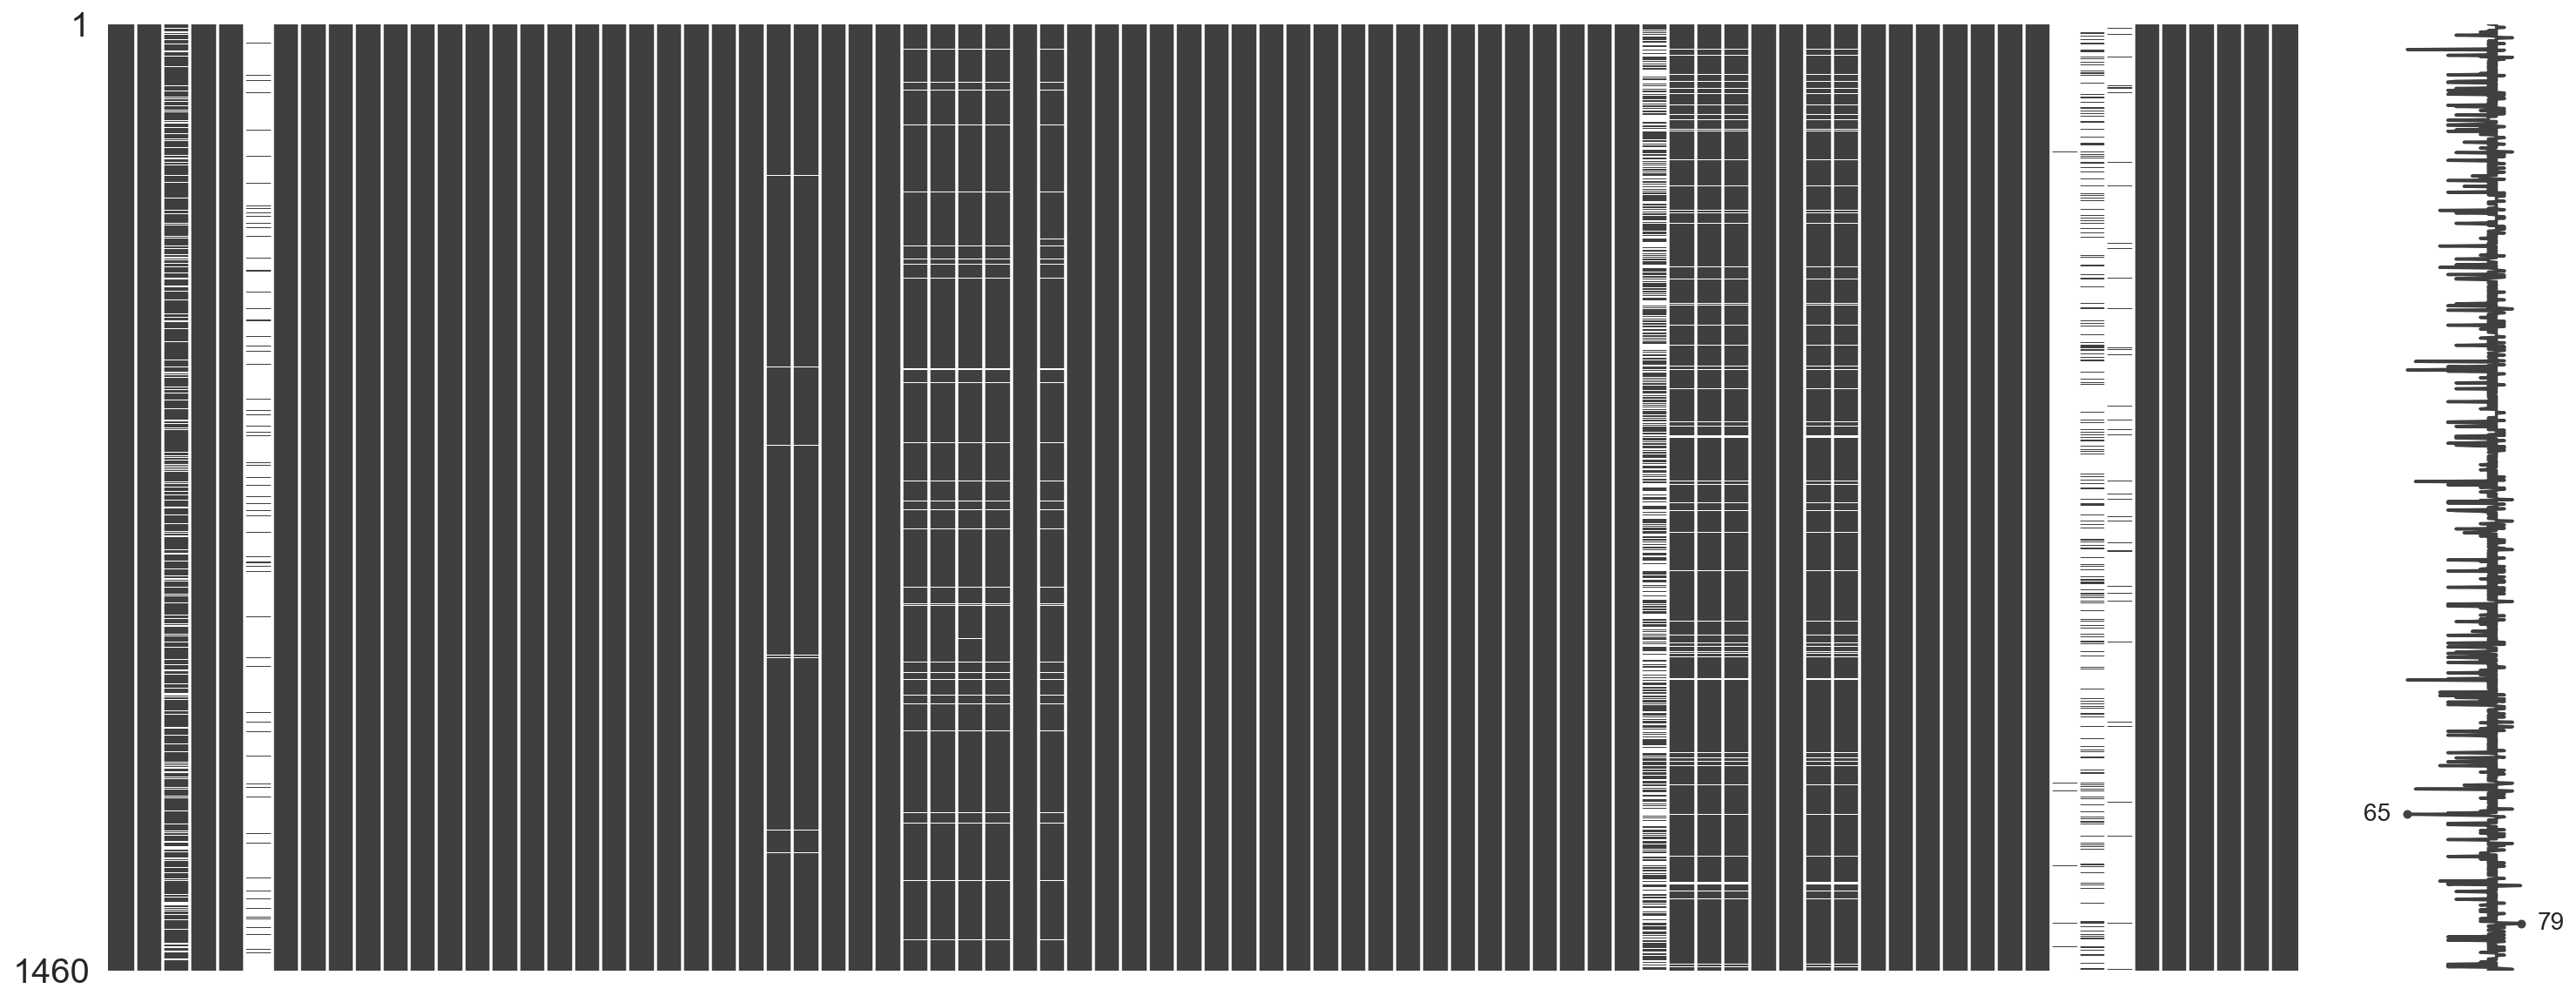

In [73]:
# The more dense the columns, the less missing values we have.
msno.matrix(house)

### Correcting missing values according to the metadata

In [5]:
# Electrical has only one missing value. WIll fill it with the value that appears the most (mode).
house.loc[house['electrical'].isnull(), 'electrical'] = 'SBrkr'

# All missing values actually are relatad to non existant or zero (except for the electrical).
house = house.fillna(0)

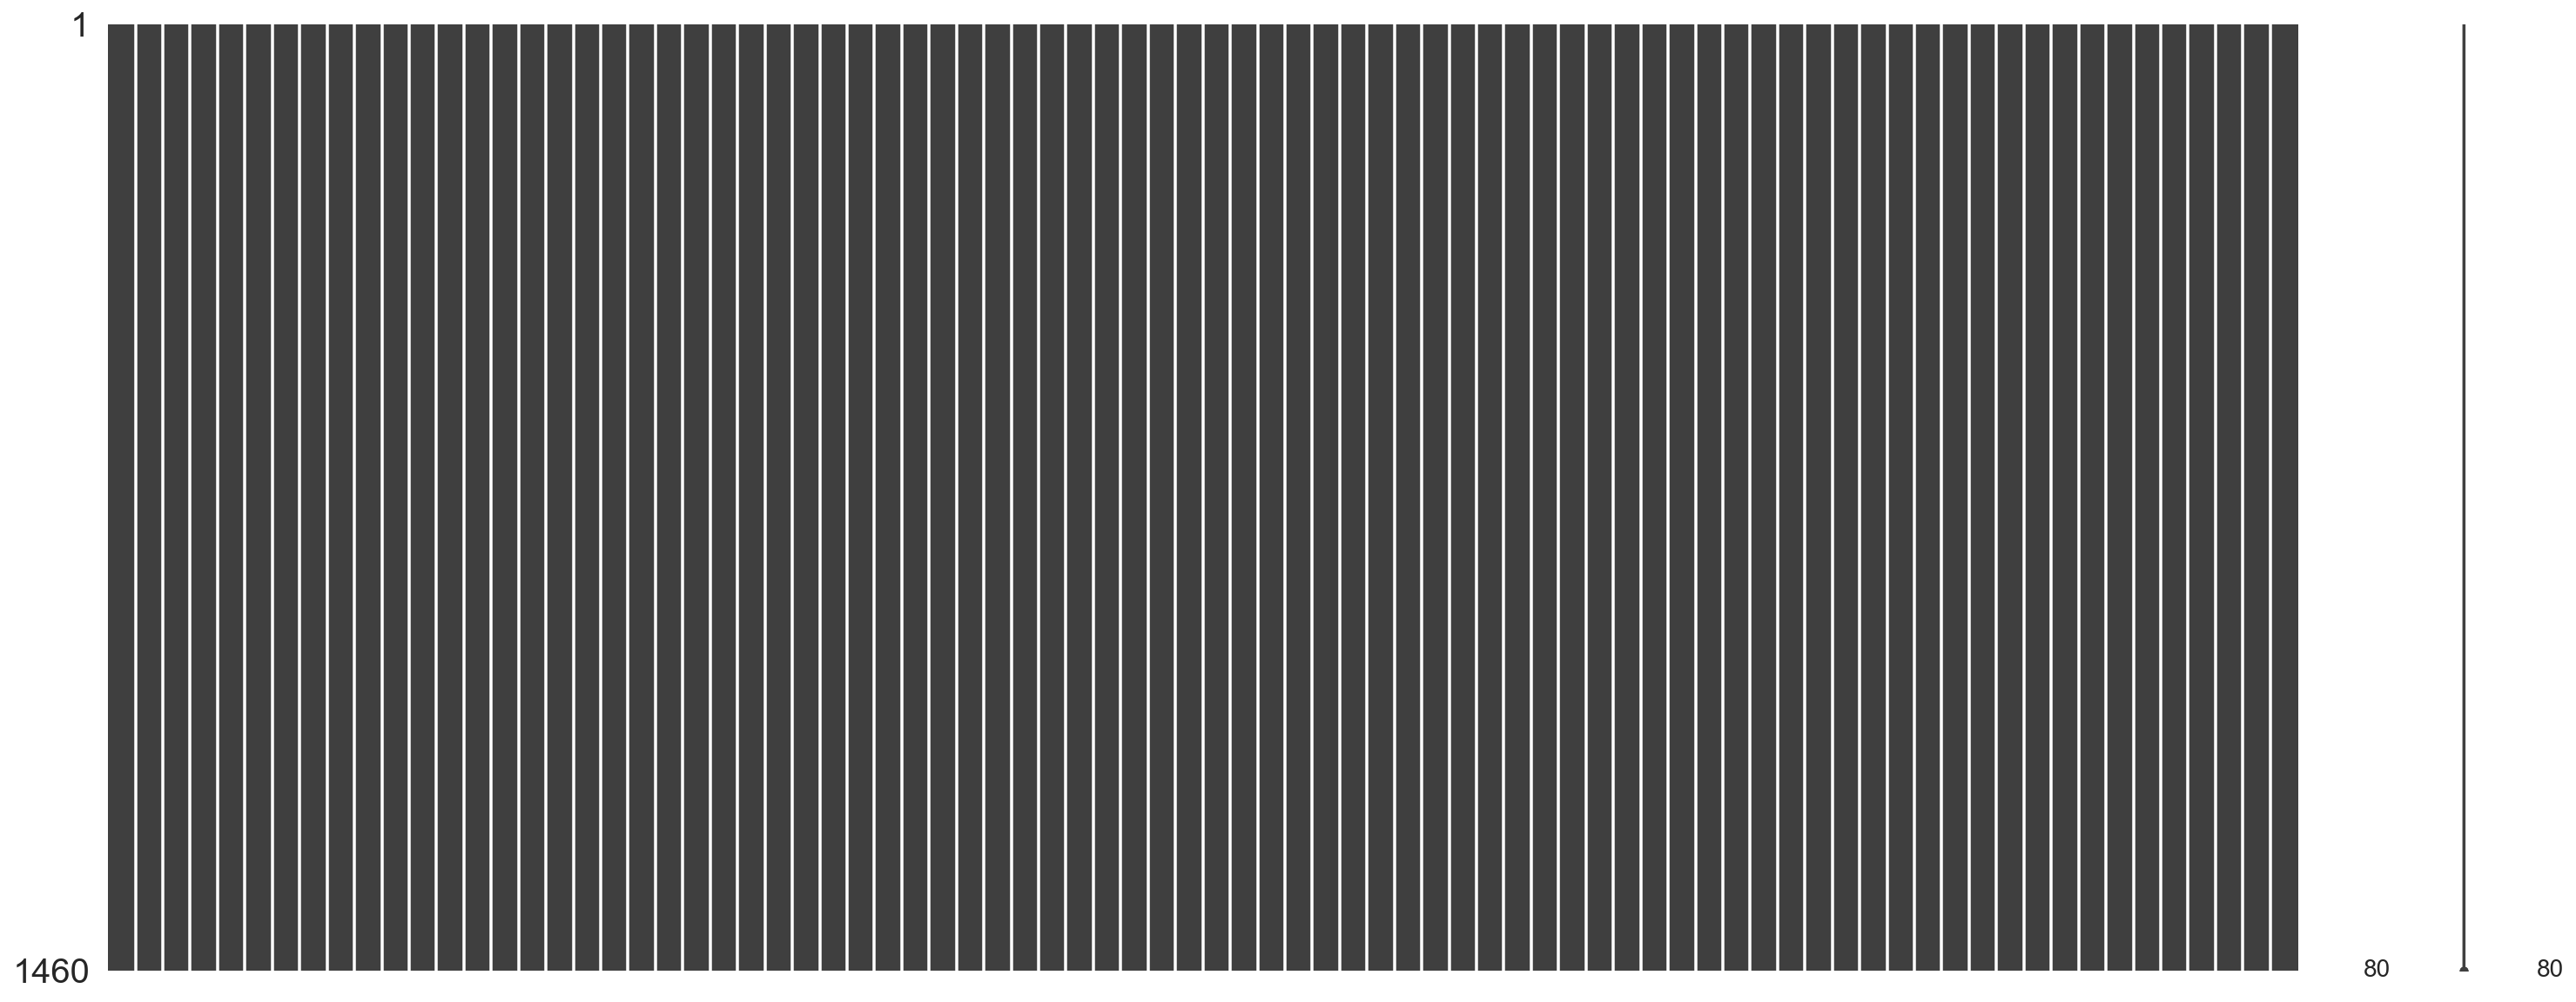

In [75]:
msno.matrix(house)

In [6]:
# There are a few commertial properties in the mix.
house.drop(index = house.loc[house['mszoning'] == 'C (all)'].index, inplace=True)

---
### 2. EDA and understanding the data

I believe the best way to go about it is looking at the whole dataset for guidelines and then doing a deep dive in to individual features and goups of featueres (eg. garagecars and garagearea).

We will understand the data and use that understanding to divide the features in to renovatabe and fixed.

First we will get an overview of the data and its relation to the target saleprice


In [27]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mssubclass     1460 non-null   int64  
 1   mszoning       1460 non-null   object 
 2   lotfrontage    1460 non-null   float64
 3   lotarea        1460 non-null   int64  
 4   street         1460 non-null   object 
 5   alley          1460 non-null   object 
 6   lotshape       1460 non-null   object 
 7   landcontour    1460 non-null   object 
 8   utilities      1460 non-null   object 
 9   lotconfig      1460 non-null   object 
 10  landslope      1460 non-null   object 
 11  neighborhood   1460 non-null   object 
 12  condition1     1460 non-null   object 
 13  condition2     1460 non-null   object 
 14  bldgtype       1460 non-null   object 
 15  housestyle     1460 non-null   object 
 16  overallqual    1460 non-null   int64  
 17  overallcond    1460 non-null   int64  
 18  yearbuil

In [29]:
house.describe().T

,count,mean,std,min,25%,50%,75%,max
mssubclass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
lotfrontage,1460.0,57.623288,34.664304,0.0,42.00,63.0,79.00,313.0
lotarea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
overallqual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
overallcond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
yearbuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
yearremodadd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
masvnrarea,1460.0,103.117123,180.731373,0.0,0.00,0.0,164.25,1600.0
bsmtfinsf1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
bsmtfinsf2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


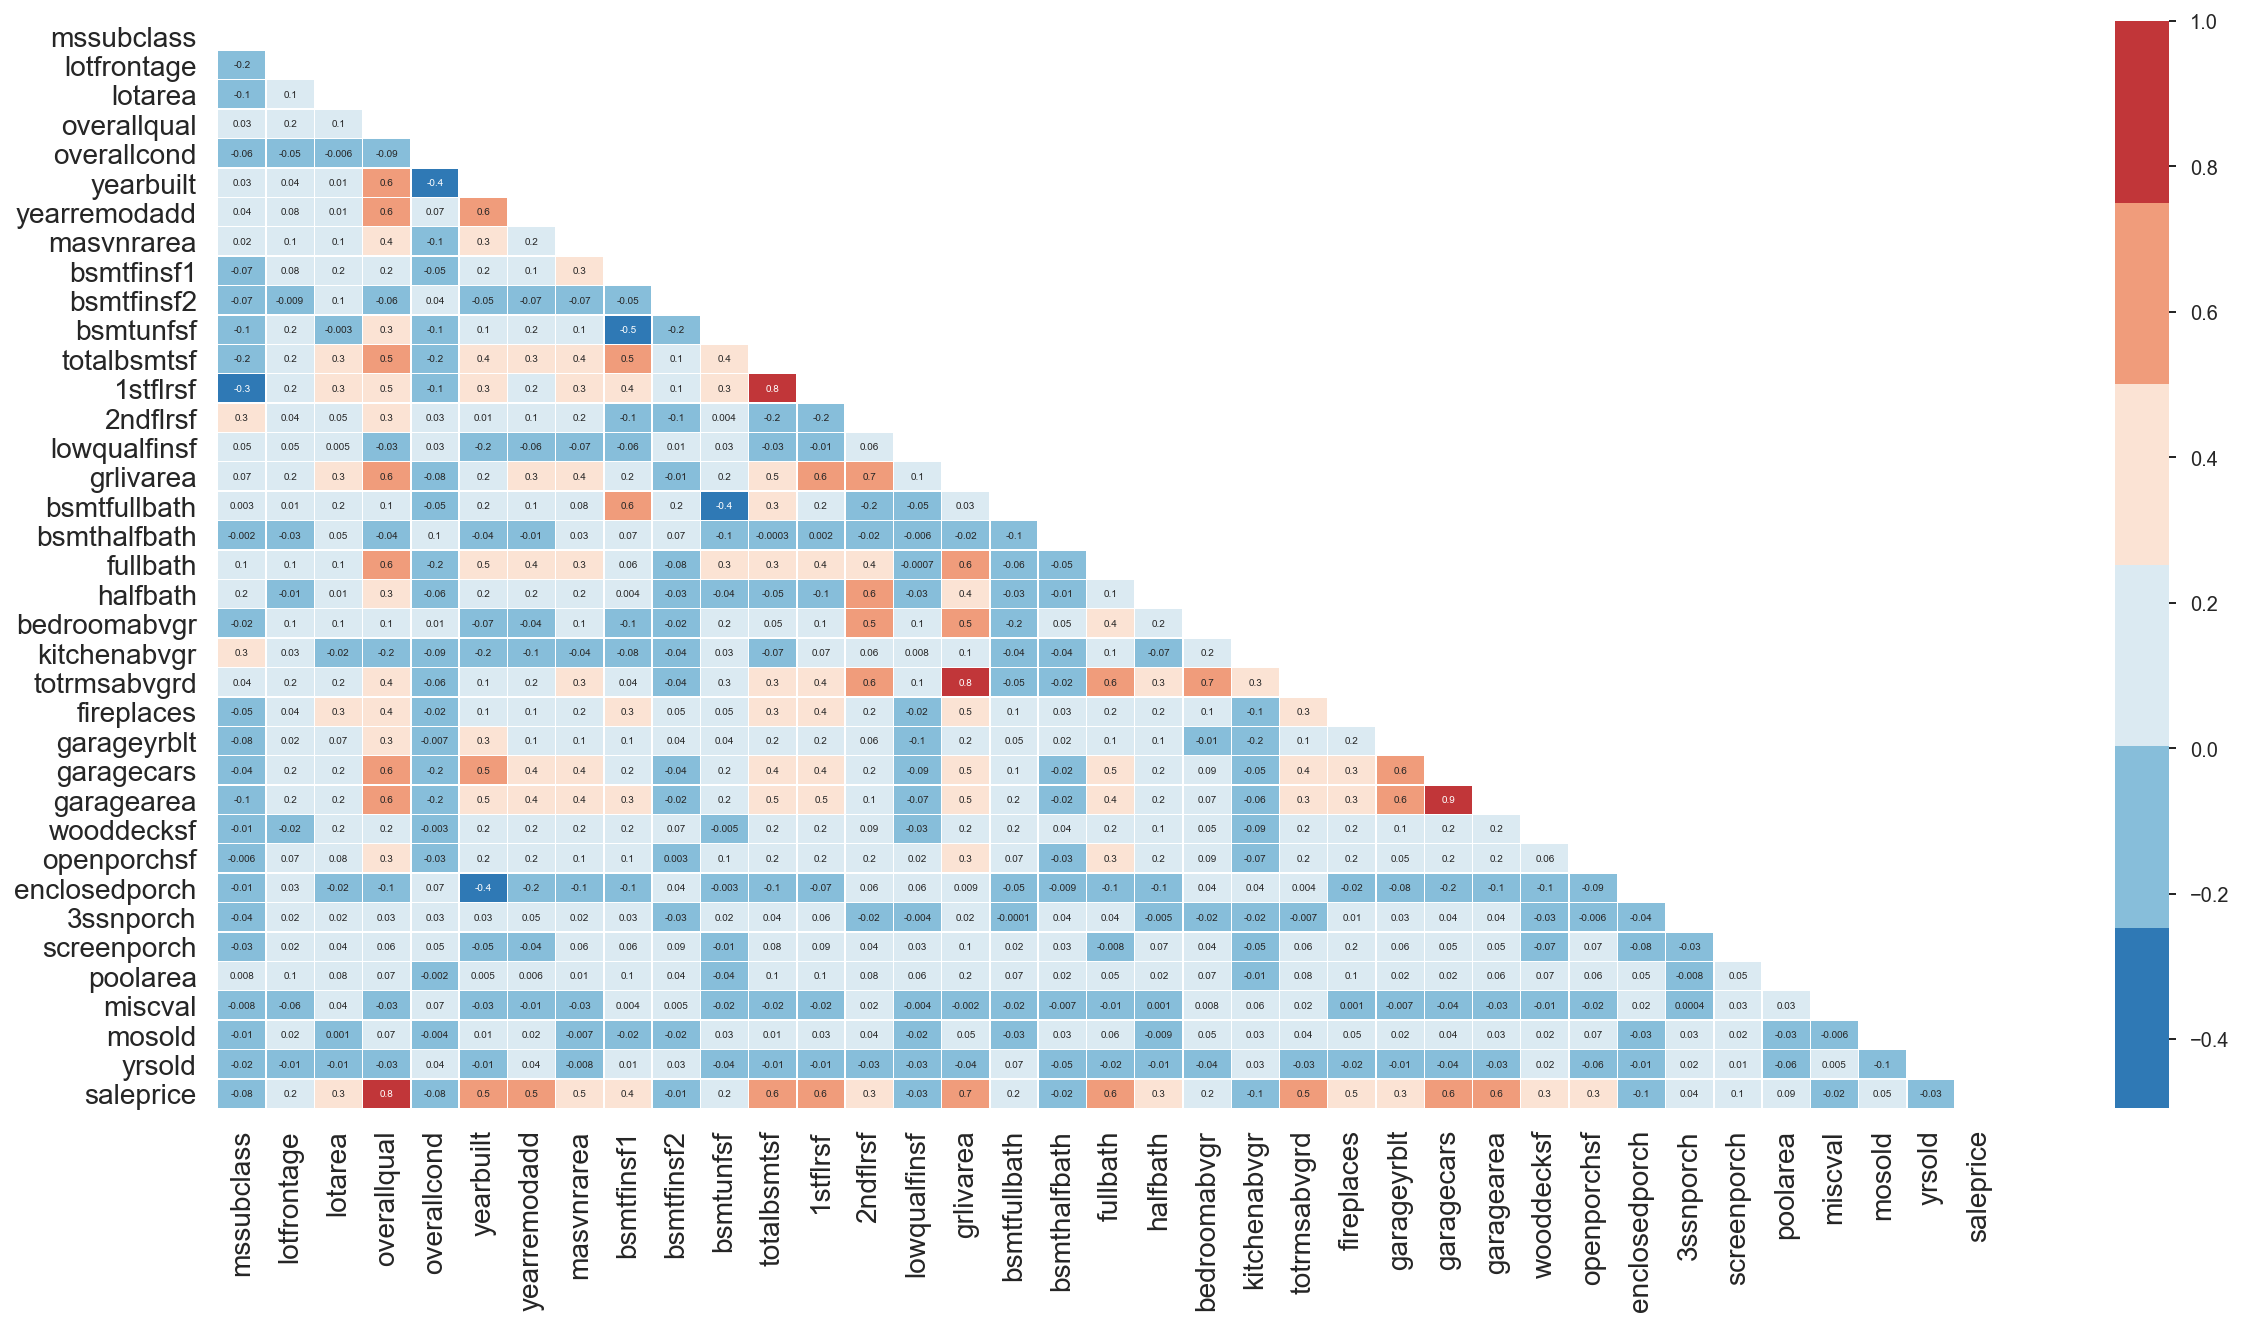

In [22]:
# Creating Correlation matrix
corrs = house.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(20,10))

# choosing color palette
c_palette = sns.color_palette('RdBu_r')

# enerate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask, annot=True,fmt='.1g', annot_kws={'fontsize':5},linewidths=.2,cmap=c_palette)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

# saving to file
plt.savefig('.\heatmap.png',dpi=300)
# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [23]:
# Looking at the most positively and negatively correlated values
print('Most positive correlated','\n',house.corr()['saleprice'].sort_values(ascending=False).head(6))
print('Most negative correlated','\n',house.corr()['saleprice'].sort_values(ascending=False).tail(5))

Most positive correlated 
 saleprice      1.000000
overallqual    0.790982
grlivarea      0.708624
garagecars     0.640409
garagearea     0.623431
totalbsmtsf    0.613581
Name: saleprice, dtype: float64
Most negative correlated 
 yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: saleprice, dtype: float64


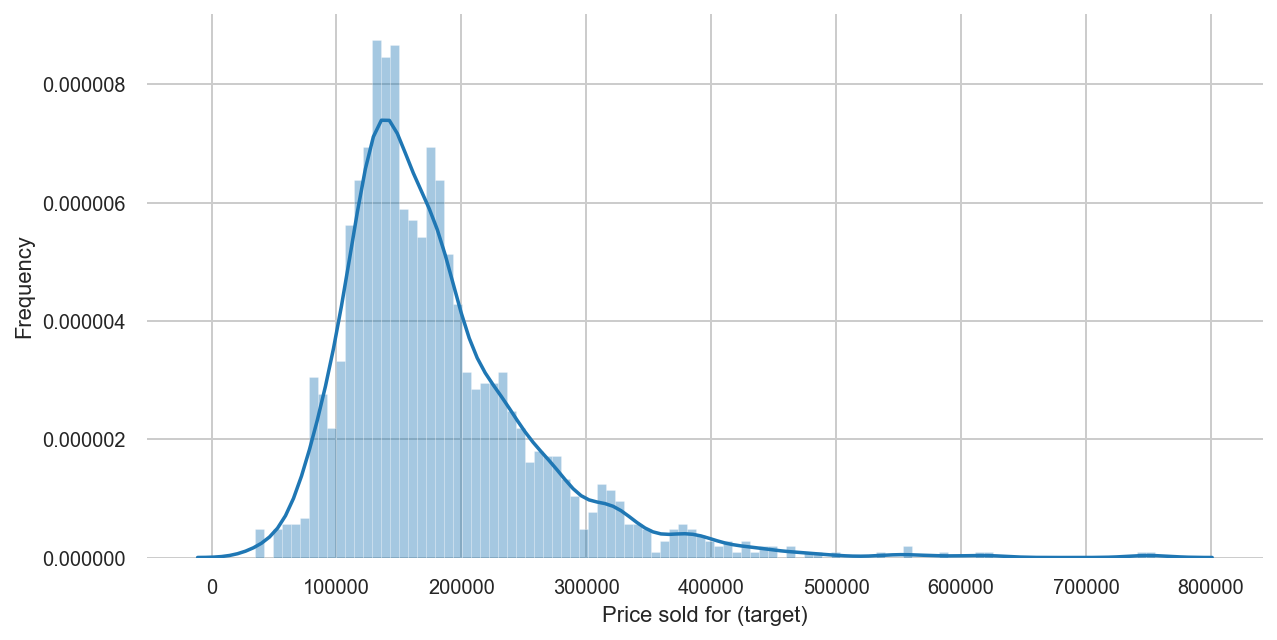

In [24]:
# Looking at the distribution of the target
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.distplot(house['saleprice'],  ax=ax, bins=100)
ax.set(xlabel='Price sold for (target)', ylabel='Frequency')
plt.show()

The plot above suggests that the target is positively skewed and has a few outliers to consider.

The plot below confirms it.

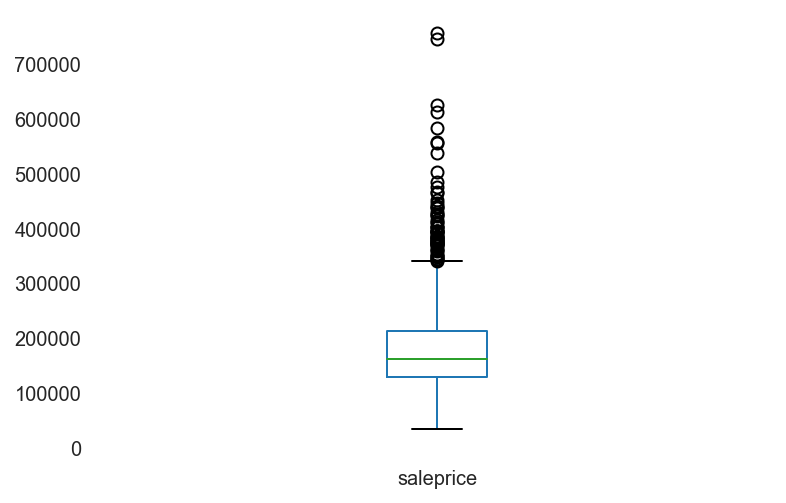

In [26]:
# Lets see if we can find any outliers here
house.boxplot(column=['saleprice'],grid=False)

In [31]:
house['saleprice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

#### Looking at the relation between features
Instead of looking at all of the data and relations between them in the notebook, lets make a function to save the plots to a folder and run automatically. This way we can look at them directly and not cutter the notebook.

`If anyone reading this notebook qats to run this code on the data or see the plots, please ask me for the csv.`

In [238]:
import os
def scatter_plotter(feature_x,df):
#     making a folder for the specifc plots
    path = '.\EDA plots\%s' % feature_x
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
#     Looping throgh all the features and plotting
    for feature_y in df.columns:
#         Plotting, and guaranteeing that discrete columns do not break the function
        try:
            sns.jointplot(x=feature_x, y=feature_y, data=house, kind="reg")
#             Saving the figure
            plotpath = path+"\joint-%s-%s.png" % (feature_x, feature_y)
            plt.savefig(plotpath ,dpi=150)
#         making the exception
        except:
            print('could not plot %s, check if it is numeric' % feature_y)
            pass
        finally:
            print("plotted "+ str((list(df.columns).index(feature_y)/len(df.columns))*100) + "%")

        

In [ ]:
%%time
for feature in house.columns:
#     print(feature)
    scatter_plotter(feature, house)

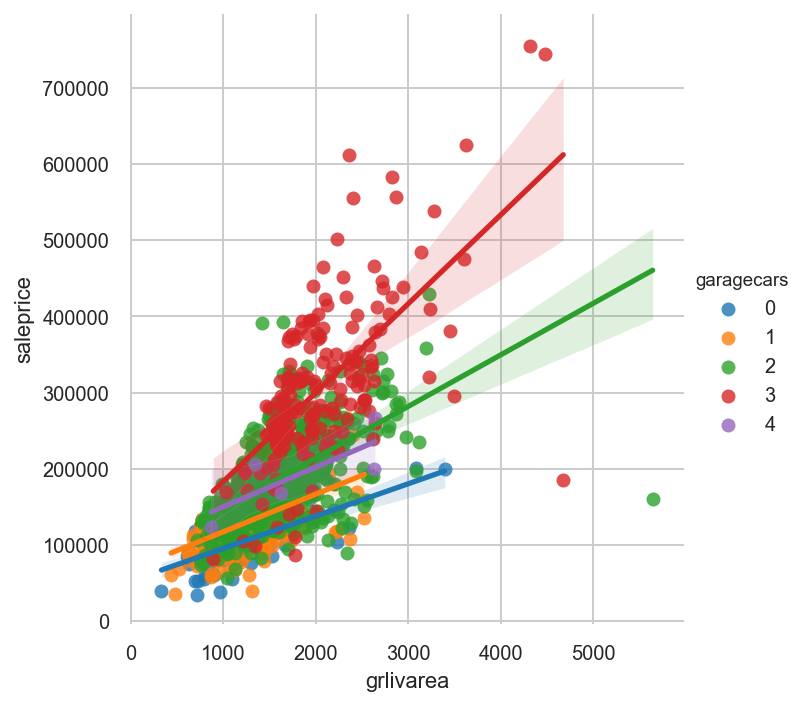

In [90]:
# This is an interesting plot to look at. This three features have a lot of significance.
sns.lmplot(x='grlivarea', y='saleprice', data=house,  hue='garagecars',height=5)

#### From EDA we gather:
1. We need to be mindful of multicolinearity for similar features (garagearea and garagecars).
2. Some features can be engineered to ensure we get pure features (more signal, less noise).

These two points will be considered during point **5. Feature Engineering**, we want to have a clear understanding of the feature importance before dropping and engineering.
    

---
### 3. Divide the data in to Fixed and Reno

Checking the different features individually and ensuring we are only using the features that are necessary for each part of the project.

#### **Fixed Features**

Discrete:
- bedroomabvgr
- bsmtfullbath
- bsmthalfbath
- fireplaces	
- fullbath
- garagecars
- garageyrblt
- halfbath
- kitchenabvgr
- mosold
- mssubclass
- yearbuilt
- yearremodadd
- yrsold
- miscval	
- totrmsabvgrd

Categorical:
- alley
- bldgtype 
- bsmtexposure
- bsmtqual
- centralair
- condition1
- condition2
- electrical
- fence
- fireplacequ
- foundation
- garagequal
- garagetype
- heating
- housestyle
- landcontour
- landslope
- masvnrtype
- miscfeature
- mszoning
- neighborhood
- paveddrive
- roofstyle
- salecondition
- saletype
- street
- utilities
- lotconfig
- lotshape

Continuous:
- 1stflrsf
- 2ndflrsf
- 3ssnporch
- enclosedporch
- garagearea
- grlivarea
- lotarea
- lotfrontage
- masvnrarea
- openporchsf
- poolarea
- screenporch
- totalbsmtsf
- wooddecksf	

#### **Reno Features**

Discrete:
- overallqual
- overallcond

Categorical:
- roofmatl
- exterior1st
- exterior2nd	
- exterqual
- extercond
- bsmtcond
- bsmtfintype1
- bsmtfintype2
- heatingqc
- kitchenqual
- functional
- garagefinish

Continuous:
- bsmtfinsf1
- bsmtfinsf2
- bsmtunfsf
- lowqualfinsf


In [7]:
# Making the fixed house features DF
fixed_house = house.filter(['1stflrsf' , '2ndflrsf' , '3ssnporch' , 'alley' , 'bedroomabvgr' , 'bldgtype' , 'bsmtexposure' , 
                                  'bsmtfullbath' , 'bsmthalfbath' , 'bsmtqual' , 'centralair' , 'condition1' , 'condition2' , 
                                  'electrical' , 'fence' , 'fireplacequ' , 'fireplaces' , 'foundation' , 'fullbath' , 'garagecars' , 
                                  'garagequal' , 'garagetype' , 'garageyrblt' , 'halfbath' , 'heating' , 'housestyle' , 'kitchenabvgr' , 
                                  'landcontour' , 'landslope' , 'masvnrtype' , 'miscfeature' , 'mosold' , 'mssubclass' , 'mszoning' , 
                                  'neighborhood' , 'paveddrive' , 'roofstyle' , 'salecondition' , 'saletype' , 'street' , 'utilities' , 
                                  'yearbuilt' , 'yearremodadd' , 'yrsold', 'enclosedporch' , 'garagearea' , 'grlivarea' , 'lotarea' , 'lotconfig' , 
                                  'lotfrontage' , 'lotshape' , 'masvnrarea' , 'miscval' , 'openporchsf' , 'poolarea' , 'screenporch' , 'totalbsmtsf' , 
                                  'totrmsabvgrd' , 'wooddecksf'])

In [8]:
# Getting the Reno features
reno_features = []
for column,number in zip(house.columns ,house.isin(fixed_house).sum()):
    if number == 0:
#         print(column)
        reno_features.append(column)
    else:
        pass
#     break

In [9]:
# making a reno DF with all features except 'saleprice'
reno_house = house.filter(reno_features[:-1])

In [87]:
# Checking the correlation to the target.
correlation = pd.DataFrame(fixed_house.join(house['saleprice']).corr()['saleprice'].sort_values(ascending=False))
correlation.rename(columns={'saleprice':'correlation'},inplace=True)
correlation.T

,saleprice,grlivarea,garagecars,garagearea,totalbsmtsf,1stflrsf,fullbath,totrmsabvgrd,yearbuilt,yearremodadd,...,screenporch,poolarea,mosold,3ssnporch,bsmthalfbath,miscval,yrsold,mssubclass,enclosedporch,kitchenabvgr
correlation,1.0,0.708658,0.642135,0.629831,0.612088,0.6033,0.556674,0.533355,0.517602,0.501186,...,0.11054,0.092396,0.051987,0.043807,-0.017561,-0.021052,-0.025391,-0.087487,-0.120765,-0.137825


---
### 4. Prepare a baseline model
Loading all the models below and making the basic test X train for the baseline model

This will be very rough... Refinement will be found below

In [10]:
from sklearn.preprocessing import LabelEncoder,StandardScaler, Binarizer, Normalizer
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor


In [263]:
# making dummie categories
dummy_house_all = pd.get_dummies(fixed_house)

In [264]:
# Determining X and y for the BM
X = dummy_house_all
y = house.saleprice
# Train mask
train_mask = X['yrsold'] != 2010
# Test Mask
test_mask = X['yrsold'] == 2010
# Train data
X_train = X[train_mask]
y_train = y[train_mask]
# test data
X_test = X[test_mask]
y_test = y[test_mask]

# Creating model object
dr = DummyRegressor().fit(X_train,y_train)

# Getting Scores
dr_acc = metrics.r2_score(y_true = y_test , y_pred = dr.predict(X_test))
print('Regressor accuracy:',dr_acc)

# getting scores  with cross validation
scores = cross_val_score(dr, X_train, y_train, cv=5)
print(scores)
print(np.mean(scores))

Regressor accuracy: -0.0012667771232202085
[-3.14891642e-03 -5.78177790e-04 -5.50688027e-03 -4.01714204e-02
 -4.64951589e-06]
-0.009882008873942683


Really bad scores that gives us a really good answer.

Indeed the features are giving us some problems here, engineering and refining will be necessary.

---
### 5. Feature Engineering
From the EDA:
1. We will work only on Fixed features for the moment.
2. Get the 'yardarea' and drop the 'lotarea'. 'grliarea' and 'lotarea' have part of the same information.
3. Get 'proximity' using 'condition1' and 'condition2'. both have similar info and increase dimentionality without adding much information.
4. Get number of rooms that are not listed and drop 'totrmsabvgrd'.
5. Look at the outliers and decide if they should receive any treatment.
6. Dummyfying categorical and discrete features.
7. Standardizing the data.

### 5.2. Getting the yard area
We will subtract the grdlivarea and lotarea to get the yard area. That can be an important point for the price of a property.

In [11]:
fixed_house['yardarea'] = fixed_house['lotarea'] - fixed_house['grlivarea']
fixed_house.drop(['lotarea'], axis=1, inplace=True)

### 5.3. Proximity to good conditions
Joining condition 1 and 2 to get the proximity to good conditions

In [12]:
fixed_house['proximity'] = fixed_house['condition1'] + fixed_house['condition2']
fixed_house.drop(['condition1','condition2'], axis=1, inplace=True)

### 5.4. Number of rooms that are not listed
Getting the number of rooms that are not kitchen, bathroom, bedroom above ground
> **Note:** 'totrmsabvgrd' does not consider bathrooms

In [13]:
fixed_house['otherrooms'] = fixed_house['totrmsabvgrd'] - fixed_house['bedroomabvgr'] - fixed_house['kitchenabvgr']
fixed_house.drop(['totrmsabvgrd'], axis=1, inplace=True)

### 5.5. Dealing with outliers
The houses that are above 4500sqft have prices that are too outside of the rest. This caracteristic  can be seen on other features too, but the "grlivarea" is the one that presents this in the most clear way.

The scatterplot below presnts the outliers clearly. The margin for the DF on the houses with 8 rooms is huge.

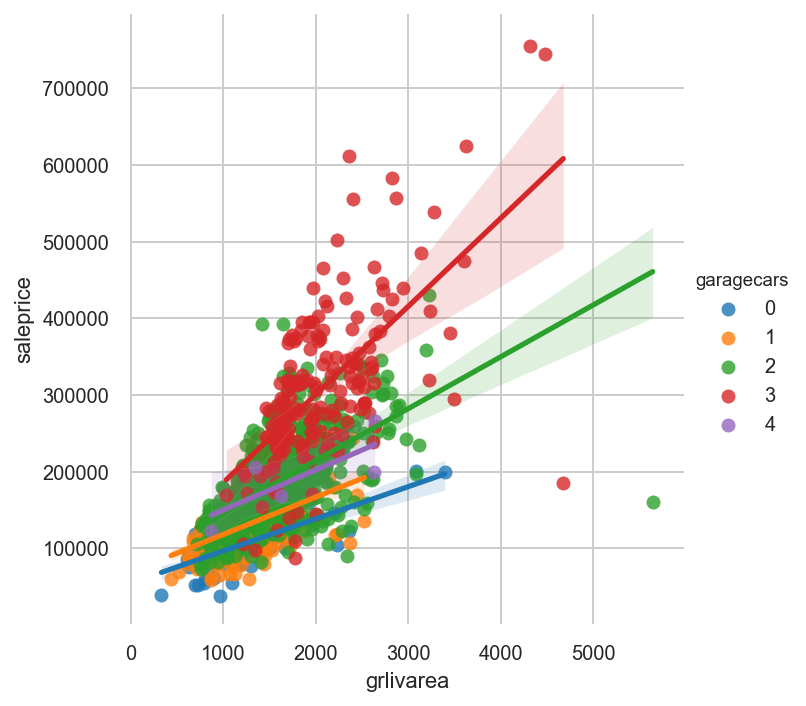

In [94]:
sns.lmplot(x='grlivarea', y='saleprice', data=fixed_house.join(house['saleprice']),  hue='garagecars',height=5)

It is likely that the outliers will help us explain the price variance in prices in the future.
Lets look at 'overallqual', 'overallcond' and 'bsmtfinsf1'.



In [151]:
# Outlier houses
reno_house[fixed_house['grlivarea']>4500][['overallqual','overallcond','bsmtfinsf1']]

,overallqual,overallcond,bsmtfinsf1
523,10,5,2260
1298,10,5,5644


Looking at the plot information above leads me to believe that this are true outliers.

Our best course of action is to drop this outliers. They will most likely skew the results. A robust regressor will probably give us better predictions and score, but we will have a worse explanation for the residuals on part 2 or the project.

In [14]:
# Commiting the outliers to a variable.
fixed_outliers = list(fixed_house[fixed_house['grlivarea']>4500].index)
# dropping them from the fixed DF
fixed_house = fixed_house.drop(fixed_outliers)
# dropping them from the reno DF
reno_house = reno_house.drop(fixed_outliers)
# dropping them from the house DF
house = house.drop(fixed_outliers)

### 5.6. Dummyfying categorical features.

Will use pandas get dummies on the categorical ones.

>One important thing to highlight here: "Why Dummies and not Labeling or counting or whatever else could have been done???"
My best answer to that is that we need to inference the feature importance and dummies will give us a better notion of what is what.

In [15]:
dummy_fixed_house = pd.get_dummies(fixed_house)
# getting the shape
dummy_fixed_house.shape

(1448, 199)

### 5.7. Standardizing the data.

Let's do it. well do the test/train split also.

In [16]:
# Determining X for the models
X = StandardScaler().fit_transform(dummy_fixed_house)
# determining y for the models
y = house['saleprice']
# Train mask
train_mask = house['yrsold'] != 2010
# Test Mask
test_mask = house['yrsold'] == 2010
# Train data
X_train = X[train_mask]
y_train = y[train_mask]
# test data
X_test = X[test_mask]
y_test = y[test_mask]

---
### 6. Test different models and inference feature importance for Q1
Finally what we all came here to see!

I will use the original Linear Regression, Lasso, huber and Random Forest to see which comes out with the best scores for us. There are other regressors we could use, but I am more confortable with this ones for now (meaning that I will not be able to explain what comes out  of their  results).

In [17]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LinearRegression, LassoCV, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [38]:
# Creating objects
lr = LinearRegression()
hr = HuberRegressor()
ls = Lasso()
lscv = LassoCV()
rf = RandomForestRegressor(n_jobs=-1)

Getting the best alphas for lasso regressors before testing the models

In [71]:
lscv = LassoCV()
possible_alphas = np.logspace(-3,10,200)
lscv = LassoCV(alphas=possible_alphas, max_iter=2000, n_jobs=-1)
lscv.fit(X_train, y_train)
print ("Best alpha is", lscv.alpha_)

Best alpha is 195.63983435170647


In [20]:
def model_tester(model):
#     fitting model to data
    fitted_model = model.fit(X_train,y_train)
#     Getting model precision
#     score = fitted_model.score(y_true = y_test, y_pred = fitted_model.predict(X_test))
    score = fitted_model.score(X_test,y_test)
#     getting mean squared error
    mse = metrics.median_absolute_error(y_test, fitted_model.predict(X_test))
#     Getting the cross validated score
    scores = cross_val_score(fitted_model, X_train, y_train, cv=5)
    print(model,'\nMean Squared Error',mse)
    print('Score',score)
    print(scores)
    print(np.mean(scores))
    print('---'*15)

In [22]:
import warnings
warnings.filterwarnings(action='ignore')
model_tester(LinearRegression())
model_tester(HuberRegressor())
model_tester(Lasso(alpha=lscv.alpha_))
model_tester(RandomForestRegressor())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 
Mean Squared Error 13668.0
Score -3.065514405214533e+24
[-2.82810397e+24 -4.25080808e+23 -5.17223350e+23 -8.58686553e+25
 -2.89892294e+25]
-2.3725658567776134e+25
---------------------------------------------
HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False) 
Mean Squared Error 12937.776935498448
Score 0.8678458646646576
[0.85878109 0.89587453 0.85454549 0.86992954 0.83625937]
0.8630780017777934
---------------------------------------------
Lasso(alpha=1023.4114021054548, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) 
Mean Squared Error 11899.559442666221
Score 0.8821839089396887
[0.86529779 0.89452789 0.86585457 0.87384138 0.83710933]
0.8673261929498253
---------------------------------------------
Rando

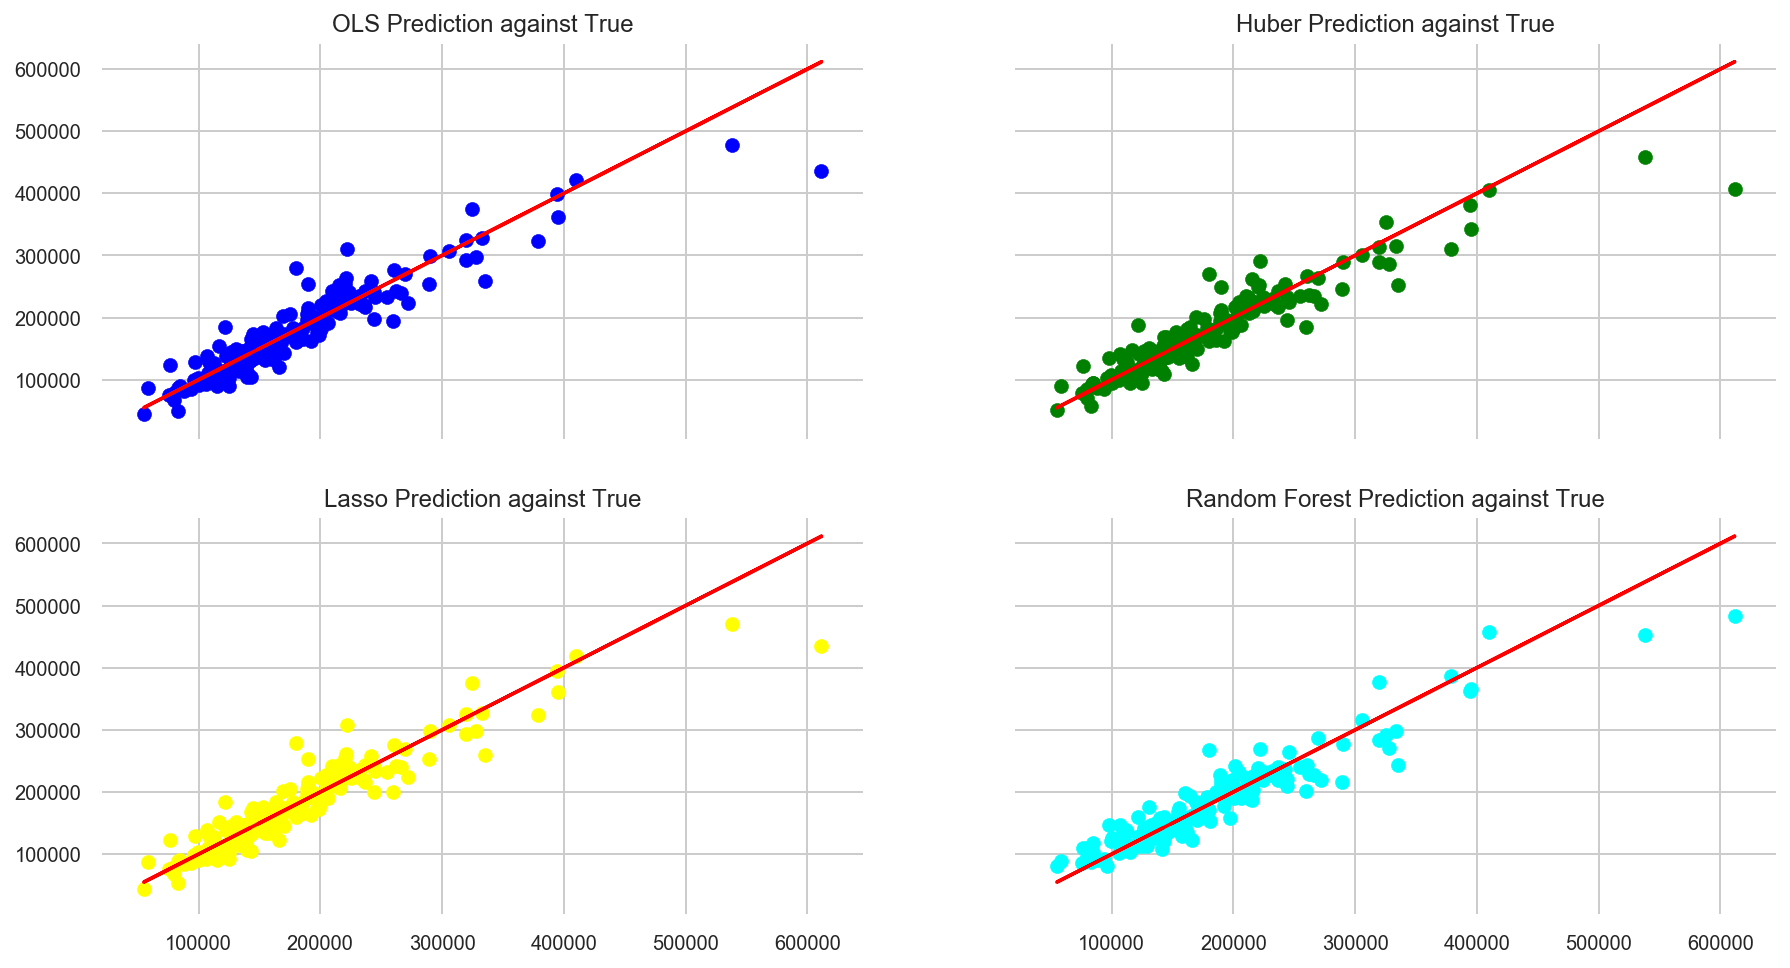

In [73]:
# Preparing the plot
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,8))
# Plotting the y_true agains the y_hat from OLS
ax1.plot(y_test, y_test, c='red')
ax1.scatter(y_test, LinearRegression().fit(X_train,y_train).predict(X_test), c='blue')
ax1.set_title('OLS Prediction against True')
# Plotting the y_true agains the y_hat from Huber
ax2.plot(y_test, y_test, c='red')
ax2.scatter(y_test, HuberRegressor().fit(X_train,y_train).predict(X_test), c='green')
ax2.set_title('Huber Prediction against True')
# Plotting the y_true agains the y_hat from OLS
ax3.plot(y_test, y_test, c='red')
ax3.scatter(y_test, Lasso(alpha=lscv.alpha_).fit(X_train,y_train).predict(X_test), c='yellow')
ax3.set_title('Lasso Prediction against True')
# Plotting the y_true agains the y_hat from OLS
ax4.plot(y_test, y_test, c='red')
ax4.scatter(y_test, RandomForestRegressor(n_jobs=-1).fit(X_train,y_train).predict(X_test), c='cyan')
ax4.set_title('Random Forest Prediction against True')
plt.show()

This was an interesting result. 

Lasso is probably giving us a good result because it is getting more signal from the strong features.

Random Forest appears to be more robust against the outliers.

Let's see the feature importance for Lasso, use those features with the Random forest (best score) and improve the hiperparameters for RFR.

In [24]:
ls = Lasso(alpha=lscv.alpha_).fit(X_train,y_train)
lasso_scores = pd.DataFrame({
    'Feature':dummy_fixed_house.columns,
    'scores':ls.coef_
})
lasso_scores = lasso_scores.sort_values('scores',ascending=False)
# All regularized features that have coeficients above 0.
lasso_scores[lasso_scores['scores'].abs()> 0]

,Feature,scores
19,grlivarea,32832.995933
26,totalbsmtsf,11356.096541
44,bsmtqual_Ex,10898.946931
14,yearbuilt,7669.791854
135,neighborhood_NoRidge,7314.272346
...,...,...
107,masvnrtype_BrkCmn,-1570.285066
119,mszoning_RM,-1712.504800
3,bedroomabvgr,-3058.210353
42,bsmtexposure_No,-3153.182533


Text(0.5, 0, 'Coefficients')

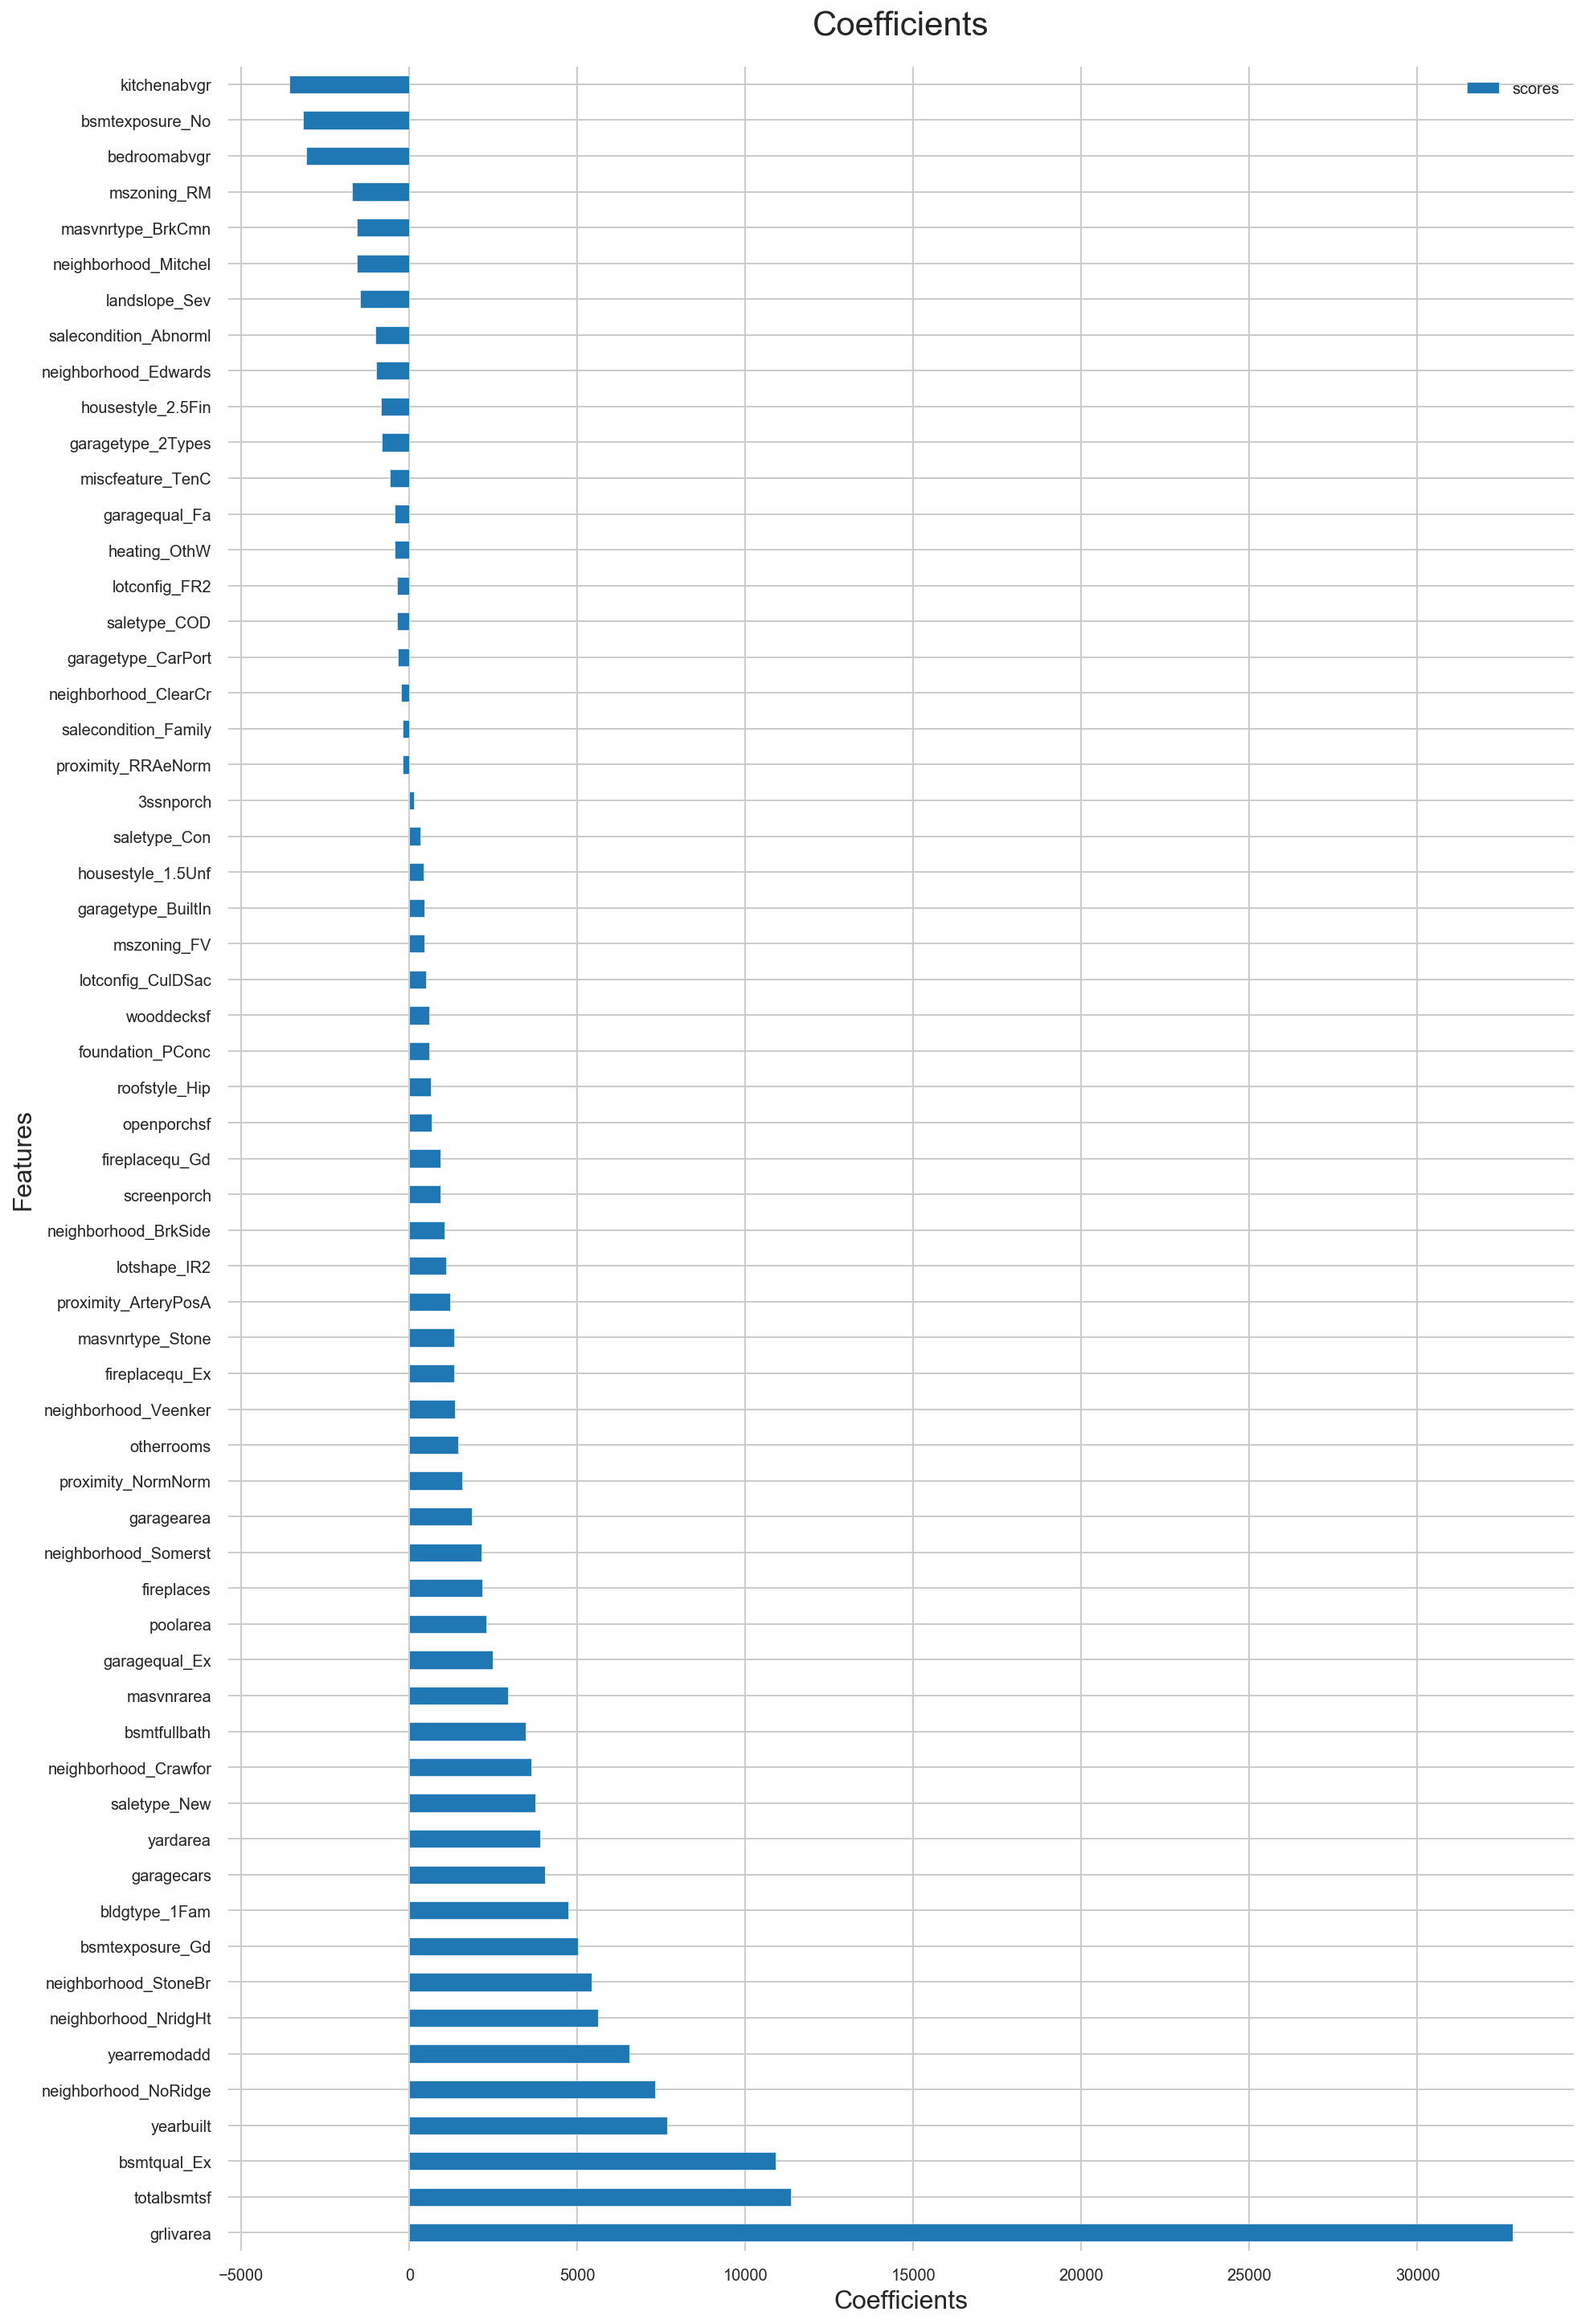

In [206]:
besf_fixed_plot = lasso_scores[lasso_scores['scores'].abs() > 100].set_index('Feature')
# Looking at the distribution of the target
ax = besf_fixed_plot.plot(kind='barh', figsize=(15,25))

# set the title
ax.set_title('Coefficients', fontsize=21, y=1.01)

# x-axis labels
ax.set_ylabel('Features', fontsize=16)

# y-axis labels
ax.set_xlabel('Coefficients', fontsize=16)

Nothing Like a good graph to help us see what is going on. Not plotting all of the features in the interest of space and to make the graph readable.

Now preparing a regularized df

In [36]:
# preparing the regularized features
regulirized_house = dummy_fixed_house[lasso_scores[lasso_scores['scores'].abs()> 0]['Feature']]
# Determining X for the models
X = StandardScaler().fit_transform(regulirized_house)
# determining y for the models
y = house['saleprice']
# Train mask
train_mask = house['yrsold'] != 2010
# Test Mask
test_mask = house['yrsold'] == 2010
# Train data
X_train = X[train_mask]
y_train = y[train_mask]
# test data
X_test = X[test_mask]
y_test = y[test_mask]

Now Gridsearch for the best params on RFR.

In [62]:
from sklearn.model_selection import GridSearchCV
# parameters to test
param_grid = {'n_estimators':[680, 690],
    'criterion':['mse'],
    'ccp_alpha':[.38,.39]}
#     'max_depth':[None], we can also use max depth as a hiperparam if we are not happy with the ccp.
gs = GridSearchCV(rf, param_grid, n_jobs=-1, cv=5)

# Using gridsearch to find the best hiperparams
gs.fit(X_train, y_train)
print(gs.best_params_)

{'ccp_alpha': 0.38, 'criterion': 'mse', 'n_estimators': 690}


In [64]:
# Random Forest with best parameters
best_rf = RandomForestRegressor(n_estimators=690, ccp_alpha=.38, n_jobs=-1).fit(X_train,y_train)
# Getting everything I believe makes sense to get from sklearn metrics
print('R squared score',metrics.r2_score(y_test,best_rf.predict(X_test)))
print('Median Absolute Error',metrics.median_absolute_error(y_test,best_rf.predict(X_test)))
print('Mean Absolute Error',metrics.mean_absolute_error(y_test,best_rf.predict(X_test)))

R squared score 0.8909752777664602
Median Absolute Error 11797.45797101449
Mean Absolute Error 17752.72055066044


As we can see above there is some variation in the errors. I am happy to keep that in the model if it means we are not overfiting and introducing  too much bias. we already regularized the features with Lasso.

The model explains 89% of the variance in the residuals of the test. There is still  $11,797.45 of the value to be explained.

let's check the model efficiency on the test data with a plot.

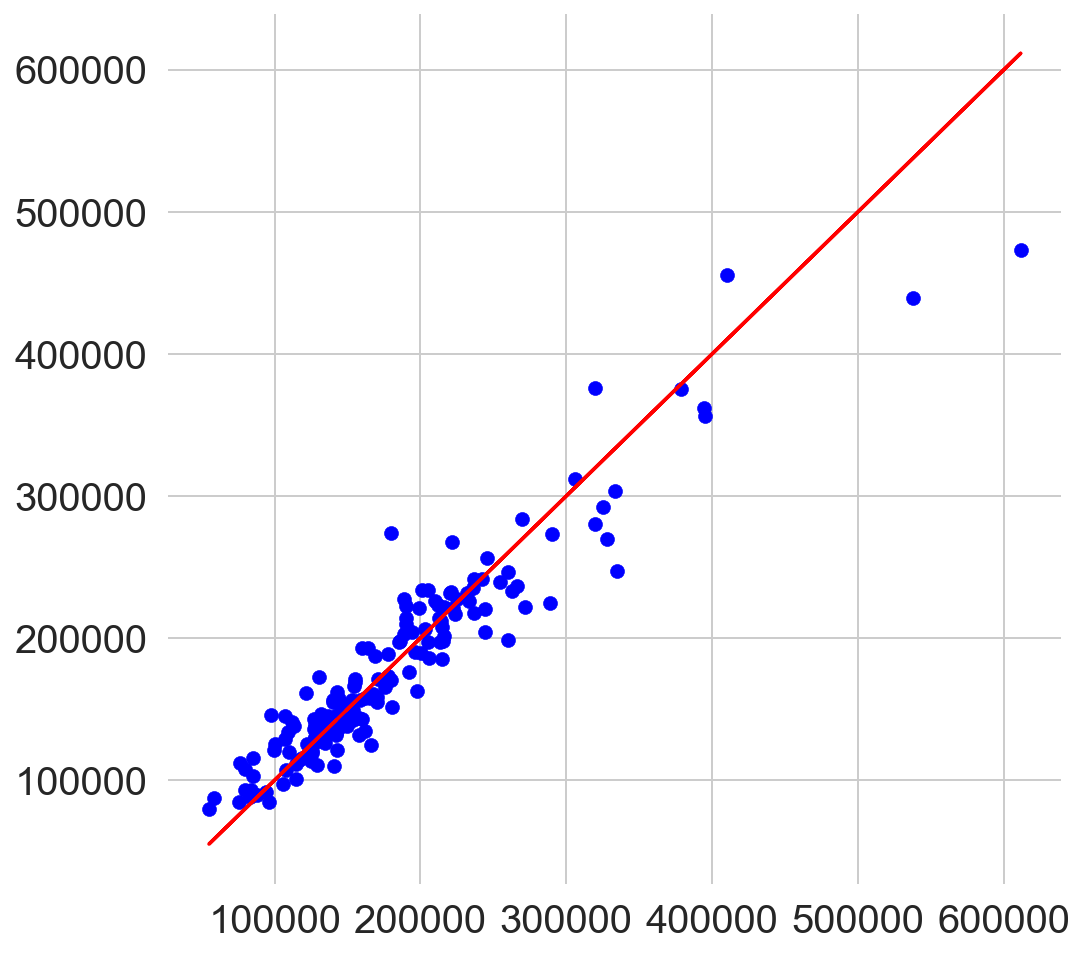

In [65]:
# Plot showing out linear forcast
fig = plt.figure(figsize=(8,8))
# change the fontsize of minor ticks label
plt.tick_params(axis='both', which='major', labelsize=20)
# get the axis of that figure
ax = plt.gca()
# plot a scatter plot on it with our data
ax.scatter(x= y_test , y=best_rf.predict(X_test), c='blue')
ax.plot(y_test , y_test , color='r');

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### 7. Do some EDA on the Reno features using the residuals from Q1 as target

1. Determine the Target and see the distribution of the target.
2. EDA on the Reno features in relation to the residuals.

### 7.1. Determine the Target and see the distribution of the target.




In [66]:
# Using lasso to get the predictions
y_pred = best_rf.predict(X)
# determining the target
y = house['saleprice'] - y_pred

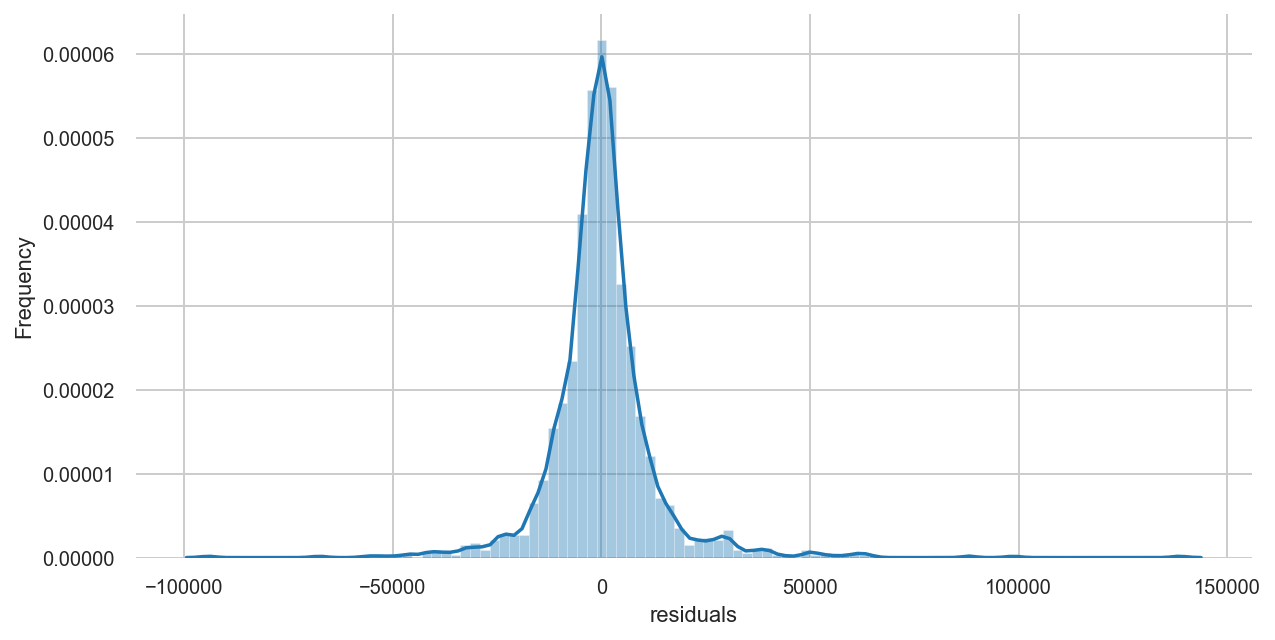

In [67]:
# Looking at the distribution of the target
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.distplot(y,  ax=ax, bins=100)
ax.set(xlabel='residuals', ylabel='Frequency')
plt.show()

This plot is looking realli good. I am happy we spend that much time with the model on the first part of the project.

In [223]:
reno_house

,overallqual,overallcond,roofmatl,exterior1st,exterior2nd,exterqual,extercond,bsmtcond,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,heatingqc,lowqualfinsf,kitchenqual,functional,garagefinish,garagecond,poolqc
0,7,5,CompShg,VinylSd,VinylSd,Gd,TA,TA,GLQ,706,Unf,0,150,Ex,0,Gd,Typ,RFn,TA,0
1,6,8,CompShg,MetalSd,MetalSd,TA,TA,TA,ALQ,978,Unf,0,284,Ex,0,TA,Typ,RFn,TA,0
2,7,5,CompShg,VinylSd,VinylSd,Gd,TA,TA,GLQ,486,Unf,0,434,Ex,0,Gd,Typ,RFn,TA,0
3,7,5,CompShg,Wd Sdng,Wd Shng,TA,TA,Gd,ALQ,216,Unf,0,540,Gd,0,Gd,Typ,Unf,TA,0
4,8,5,CompShg,VinylSd,VinylSd,Gd,TA,TA,GLQ,655,Unf,0,490,Ex,0,Gd,Typ,RFn,TA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,5,CompShg,VinylSd,VinylSd,TA,TA,TA,Unf,0,Unf,0,953,Ex,0,TA,Typ,RFn,TA,0
1456,6,6,CompShg,Plywood,Plywood,TA,TA,TA,ALQ,790,Rec,163,589,TA,0,TA,Min1,Unf,TA,0
1457,7,9,CompShg,CemntBd,CmentBd,Ex,Gd,Gd,GLQ,275,Unf,0,877,Ex,0,Gd,Typ,RFn,TA,0
1458,5,6,CompShg,MetalSd,MetalSd,TA,TA,TA,GLQ,49,Rec,1029,0,Gd,0,Gd,Typ,Unf,TA,0


Text(0.5, 34.400000000000006, 'Coefficients')

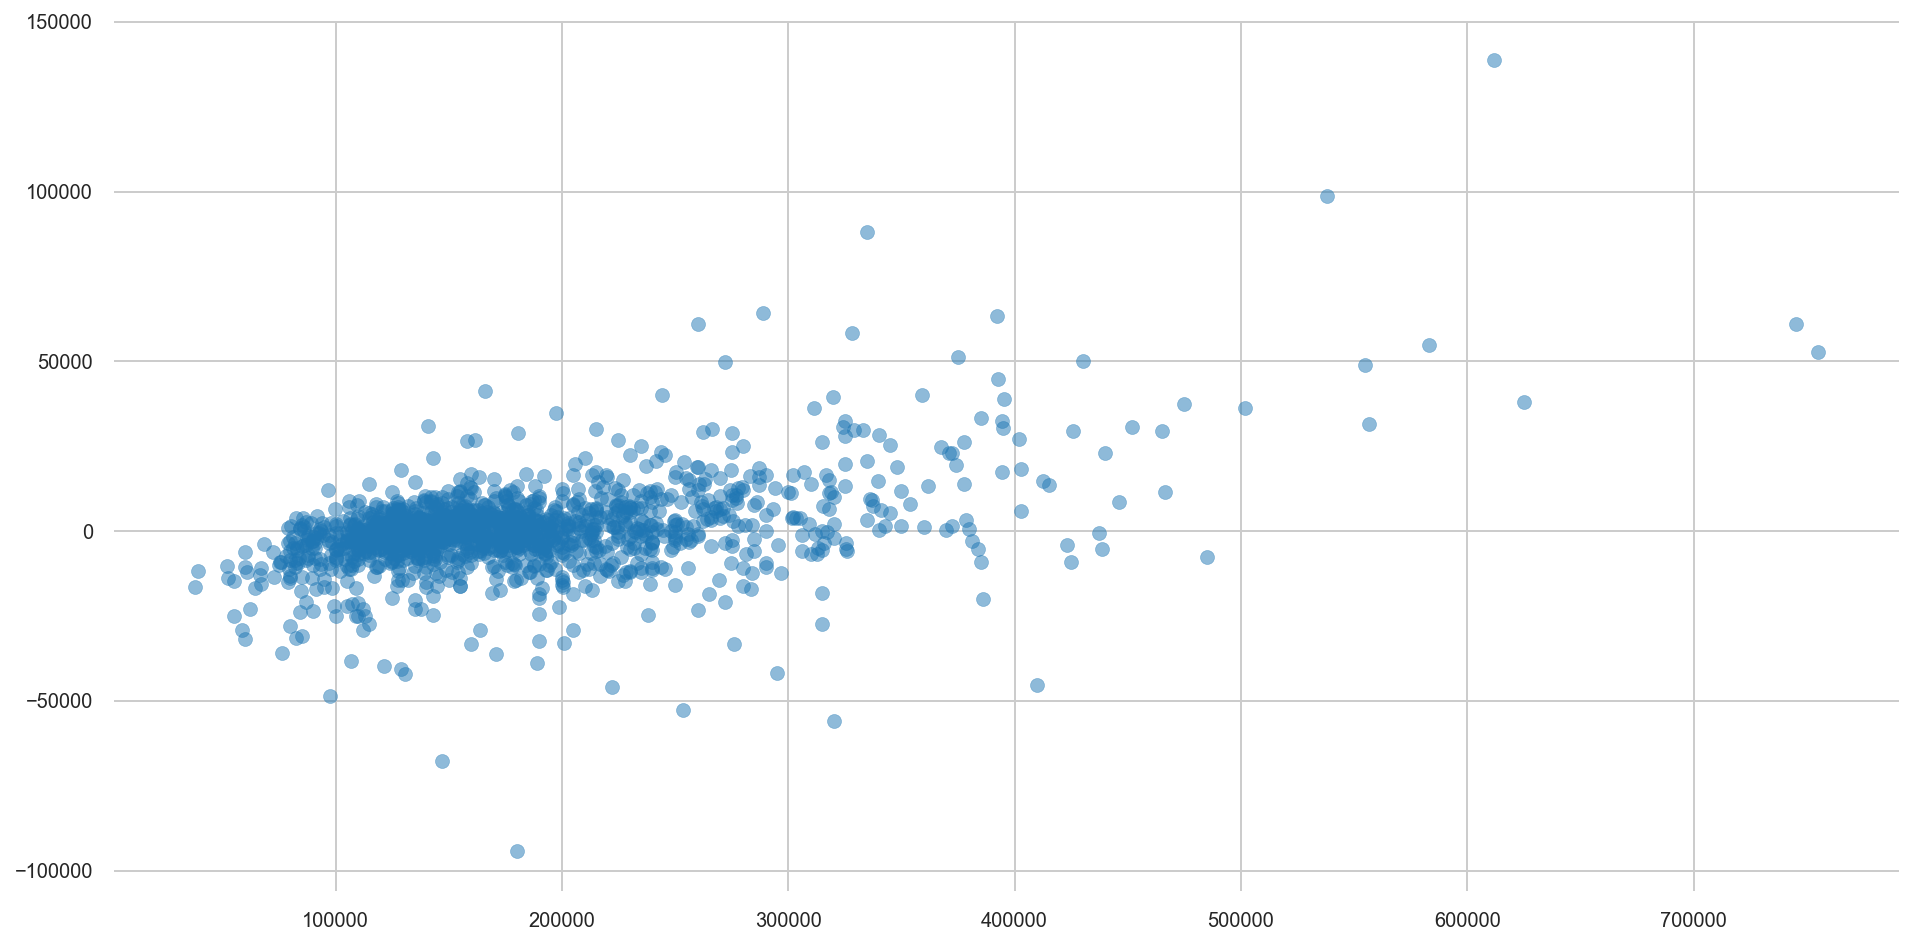

In [68]:
# Creating figure
fig = plt.figure(figsize=(16,8))
# Plotting the residuals against the actual price
plt.scatter(house['saleprice'] ,y, alpha=.5)
# x-axis labels
ax.set_ylabel('Features', fontsize=16)
# y-axis labels
ax.set_xlabel('Coefficients', fontsize=16)

The residuals seem fairly linear, which shows that the model on question 1 is working well on the dataset.

This also shows that the higher the price, the more we get a variation in the residuals, sudgesting that the increase in price is mostly predicted by the fixed features, but the reno features have a measurable impact.



---
### 7.2. EDA on the Reno features in relation to the residuals. 
We need to find  which of the remaining features actually have an inpact in the residuals.

First, what are the remaining features?

In [237]:
reno_house.columns

Index(['overallqual', 'overallcond', 'roofmatl', 'exterior1st', 'exterior2nd',
       'exterqual', 'extercond', 'bsmtcond', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'heatingqc', 'lowqualfinsf',
       'kitchenqual', 'functional', 'garagefinish', 'garagecond', 'poolqc'],
      dtype='object')

In [ ]:
%%time
for feature in reno_house.columns:
#     print(feature)
    scatter_plotter(feature, reno_house)

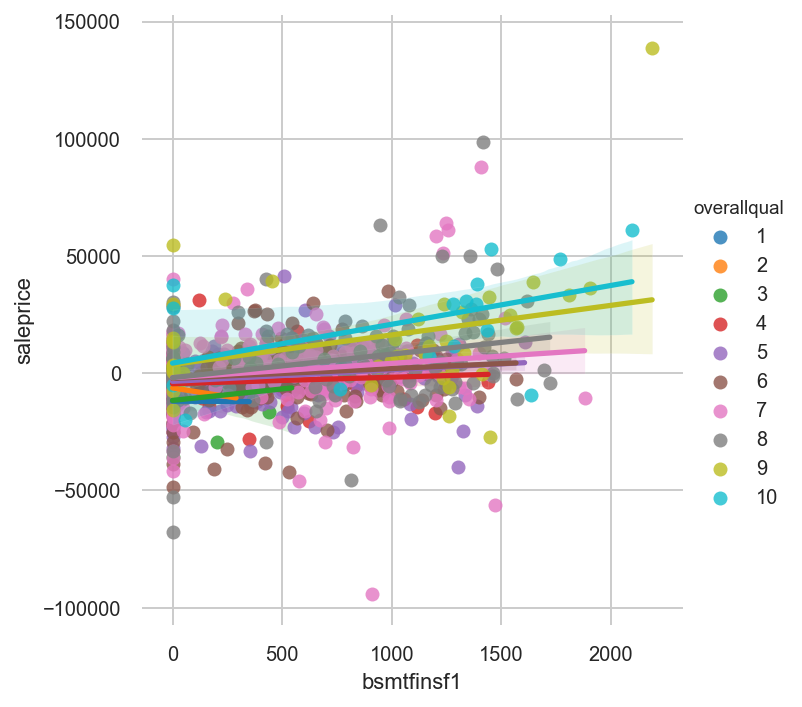

In [74]:
# The features are not as clear as we had them n the first part of the project
sns.lmplot(x='bsmtfinsf1', y='saleprice', data=reno_house.join(y), hue='overallqual', height=5)

### 8. Repeat steps 4,5 and 6 for Q2 using the residuals from Q1 as the target.

1. Prepare a baseline model
2. Feature engineering
3. Test different models and inference feature importance for Q1


### 8.1. Prepare a baseline model




In [75]:
# making dummie categories
reno_dummy_all = pd.get_dummies(reno_house)

# Determining X and y for the BM
X = reno_dummy_all

# Train mask
train_mask = house['yrsold'] != 2010
# Test Mask
test_mask = house['yrsold'] == 2010
# Train data
X_train = X[train_mask]
y_train = y[train_mask]
# test data
X_test = X[test_mask]
y_test = y[test_mask]

# Creating model object
dr = DummyRegressor().fit(X_train,y_train)

# Getting Scores
dr_acc = metrics.r2_score(y_true = y_test , y_pred = dr.predict(X_test))
print('Regressor accuracy:',dr_acc)

# getting scores  with cross validation
scores = cross_val_score(dr, X_train, y_train, cv=5)
print(scores)
print(np.mean(scores))

Regressor accuracy: -0.0010158517501581699
[-1.62815384e-07 -3.54717687e-03 -7.20698514e-03 -1.96741870e-02
 -1.72447327e-03]
-0.00643059702339599


Dismal result again

### 8.2. Feature engineering

As we did with the fixed features, we should try to combine columns that have the same information in to one stronger feature and then drop the original features to guarantee there is no multicolinearity and ensure we clear the signal for the model.

The other only interesting thing that will help us with the inferences is to turn the quality and condition in to categorical features.

Looking at the features, there is really only one feature that makes sense to add up. The `basement` finished areas.

In [76]:
# Making a copy of the DF
reno_engineered = reno_house.copy()

In [81]:
# Will also combine the types of finishe for basement in to one feature.
reno_engineered['bsmtfintotal'] = reno_engineered['bsmtfinsf1']+reno_engineered['bsmtfinsf2']

# Dropping the doubled features
reno_engineered.drop(['bsmtfinsf1','bsmtfinsf2'], axis=1, inplace=True)

In [109]:
# Turning the quality and condition to categorical
reno_engineered['overallqual'] = reno_engineered['overallqual'].astype(str)
reno_engineered['overallcond'] = reno_engineered['overallcond'].astype(str)

### making the dummy categories for modeling

In [110]:
reno_dummy = pd.get_dummies(reno_engineered)
reno_dummy.shape

(1448, 118)

### Dividing train/test and Standardizing

In [123]:
# Standardized Train splits
X_train = StandardScaler().fit_transform(reno_dummy[train_mask])
y_train = y[train_mask]
# Standardized Test split
X_test = StandardScaler().fit_transform(reno_dummy[test_mask])
y_test = y[test_mask]

---
### 8.3.Test different models and inference feature importance
This time we will use elasticnet with gridsearch to figure out if we shoudl go with Lasso is a good idea to regularize the features.

In [112]:
from sklearn.linear_model import ElasticNet
hiperparameters = {
    "l1_ratio": np.linspace(0.01,1,30),
    "alpha": np.logspace(.01, 10, 40)}

en = ElasticNet()
en_gs_cv = GridSearchCV(en , param_grid = hiperparameters , verbose = 1 , n_jobs= -1)

In [113]:
en_gs_cv.fit(X_train , y_train)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 944 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 2944 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 5744 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   23.1s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([1.02329299e+00, 1.84566912e+00, 3.32895322e+00, 6.00428832e...
       0.18068966, 0.21482759, 0.24896552, 0.28310345, 0.31724138,
       0.35137931, 0.38551724, 0.41965517, 0.4537931 , 0.48793103,
       0.52206897, 0.5562069 , 0.59034483, 0.62448276, 0.65862069,
       0.69275862, 0.72689655, 0.76103448, 0.79517241, 0.82931034,
       0.86344828, 0.89758621, 0.93172414, 0.96586207, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [114]:
# Getting prediction
prediction = en_gs_cv.predict(X_test)
# Getting the score
metrics.r2_score(y_test, prediction)

0.1468851842623925

In [115]:
# Getting the best parameters
en_gs_cv.best_params_

{'alpha': 206.72100865923898, 'l1_ratio': 1.0}

The parameters above suggest that we should use a Lasso regression. Next step will be to do a Lasso regression with the alphas we got and see if the score is better than the ElasticNet.

In [116]:
# preparing object with the best number for alpha
ls = Lasso(alpha =206.72100865923898)
# getting predictions
predictions = ls.fit(X_train,y_train).predict(X_test)
# getting scores
print('R squared score',round(metrics.r2_score(y_test,ls.predict(X_test))*100))
print('Median Absolute Error',metrics.median_absolute_error(y_test,ls.predict(X_test)))
print('Mean Absolute Error',metrics.mean_absolute_error(y_test,ls.predict(X_test)))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_test,ls.predict(X_test))))


R squared score 15.0
Median Absolute Error 10536.329002366863
Mean Absolute Error 16340.803689927507
RMSE 24296.994599069527


Ok, lets test the same regressors we had on the previous part of the project. The scores are likely to be better.

In [117]:
warnings.filterwarnings(action='ignore')
model_tester(LinearRegression())
model_tester(HuberRegressor())
model_tester(Lasso(alpha=206.72100865923898))
model_tester(RandomForestRegressor())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 
Mean Squared Error 6363880340348334.0
Score -5.210174370668628e+23
[-1.79891361e+27 -9.38221472e+26 -3.23120520e+26 -3.77823234e+27
 -2.54525482e+25]
-1.3727880991985338e+27
---------------------------------------------
HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False) 
Mean Squared Error 10775.935492927409
Score 0.14349619565113003
[0.0869132  0.26903265 0.17769272 0.19435552 0.22158512]
0.1899158411310891
---------------------------------------------
Lasso(alpha=206.72100865923898, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) 
Mean Squared Error 10536.329002366863
Score 0.1468851842623925
[0.1209811  0.27908595 0.17523632 0.23083556 0.25334175]
0.21189613541685892
--------------------------------------

RFR has the best score but larger variance.

Lasso has the smallest variance and a middle score.

Again, Huber did not score at the top of all other 

Let's look at the feature importance again and infere on the result.

In [124]:
ls = Lasso(alpha=lscv.alpha_).fit(X_train,y_train)
lasso_scores = pd.DataFrame({
    'Feature':reno_dummy.columns,
    'scores':ls.coef_
})
lasso_scores = lasso_scores.sort_values('scores',ascending=False)
# All regularized features that have coeficients above 0.
lasso_scores[lasso_scores['scores'].abs()> 0]

,Feature,scores
4,overallqual_10,1745.891748
32,exterior1st_BrkFace,1338.968246
12,overallqual_9,1192.506203
2,bsmtfintotal,954.893427
11,overallqual_8,873.886023
28,roofmatl_WdShngl,845.937519
103,functional_Typ,740.078561
19,overallcond_7,433.544279
47,exterior2nd_BrkFace,420.537545
23,roofmatl_Membran,392.101786



### Let's look at the three main points that the feature importance shows us:

1. Houses that have a functional, but unfinished, basement. Putting finishing’s on can increase the value of the house significantly.
2. Placing a brick fence on the house.
3. Renovating the kitchen to make it in to high quality.


